<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, pathloss step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
from astropy.io import fits

import jwst
from jwst.pathloss import PathLossStep
from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/requirements.txt

# import NPTT
import nirspec_pipe_testing_tool as nptt

In [2]:
# VERSIONS

# print the jwst pipeline version
print("Using JWST pipeline version: ", jwst.__version__)

# Make sure that the version used is the right one

# to get the latest version from 'master' run:
# subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

latest_nptt_stable_version = '1.1.1'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("\n* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

Using JWST pipeline version:  0.16.2

* WARNING - The code might break because the version used is not the latest stable version:
            Latest stable version is  1.1.1
            Using NPTT version  1.1.1.dev4+gb2081e9


<a id="intro_ID"></a>
# Introduction

The NIRSpec team developed an implementation of the pathloss step and compared the output to the pipeline output for this step. We expected machine precision differences (about 10^-7) but due to rounding differences in interpolation methods we relaxed the difference threshold to 10^-6. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py. There is a corresponding script for Multi Object Spectroscopy (MOS) and for Integral Field Unit (IFU) data. Each mode has a script for point source (ps) and for uniform source (uni).


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/pathloss


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only FS and MOS, since extract_2d is skipped for IFU. Data sets are:
- FS_FULLFRAME_G395H_F290LP
- FS_ALLSLITS_G140H_F100LP 
- MOS_G140M_LINE1 
- IFU_G395H_F290LP

The testing data can be located at ``path_to_nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite```

In that directory you will find a subdirectory for CV3 data for FS, MOS, and IFU, as well as other campaigns. This notebook is specifically written for CV3 data.



[Top of Page](#title_ID)

Set the following variables to the file you are interested in testing:

- output_directory = path where you want intermediary files and plots to be saved in

- input_file = this is the previous step file, e.g. jwtest1_NRS1_source_type.fits

- mode_used = supported modes are: FS, MOS, IFU, BOTS, MOS_sim, dark, image, confirm, taconfirm, wata, msata, focus, mimf

- raw_data_root_file = CV3 raw data file


<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the pathloss step, use the command:

$ strun jwst.pathloss.PathLossStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.pathloss import PathLossStep
 
$\gt$ PathLossStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:

- output_directory = path where you want intermediary files and plots to be saved in

- input_file = this is the previous step file, e.g. jwtest1_NRS1_source_type.fits

- mode_used = supported modes are: FS, MOS, IFU, BOTS, MOS_sim, dark, image, confirm, taconfirm, wata, msata, focus, mimf

- raw_data_root_file = CV3 raw data file


<a id="Common_variables"></a>
# Common Variables

In [3]:
# Set common variables for entire notebook

# paths
vault_path = os.path.join(os.environ.get('WIT4_PATH'), 'nirspec_vault')
test_data_path = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data'

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-05

# other variables
writefile = False
show_figs = True
save_figs = False

<a id="FULLFRAME"></a>
# FS FULL-FRAME test

In [4]:
# Set the variables for Fixed Slit (FS) data
data_directory = os.path.join(test_data_path, 'FS_FULL_FRAME/G395H_opaque')
prev_step_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_srctype.fits')
mode_used = 'FS'
comparison_file = prev_step_file.replace('srctype', 'pathloss')
extract2d_file = prev_step_file.replace('srctype', 'extract_2d')

In [5]:
# Run the pipeline step
pipe_result = PathLossStep.call(prev_step_file)

2020-09-25 15:50:36,563 - CRDS - ERROR -  Error determining best reference for 'pars-pathlossstep'  =   Unknown reference type 'pars-pathlossstep'
2020-09-25 15:50:36,565 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2020-09-25 15:50:36,667 - stpipe.PathLossStep - INFO - Step PathLossStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G395H_opaque/final_output_caldet1_NRS1_srctype.fits',).
2020-09-25 15:50:36,669 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-25 15:50:39,484 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits
2020-09-25 15:50:39,574 - stpip

In [6]:
# Obtain other the information

# determine the type of source from the science header, choose the first science extension
srouce_type = fits.getval(prev_step_file, "SRCTYPE", "SCI", 1)

# get the corresponding reference file from the main header
reffile = pipe_result.meta.ref_file.pathloss.name.replace("crds://", "")
reffile_path = os.path.join(os.environ.get('CRDS_PATH'), 'references/jwst/nirspec/'+reffile)


step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G395H_opaque/final_output_caldet1_NRS1_srctype.fits
path_loss_file  -->  Grating:G395H   Filter:F290LP   EXP_TYPE:NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Checking if files exist & obtaining datamodels.
          This takes a few minutes...
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits


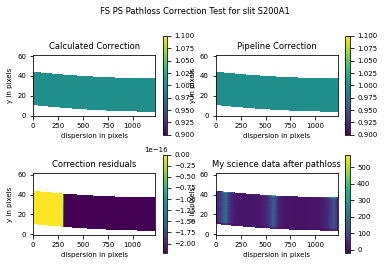

2020-09-25 15:51:39,864 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:448: RuntimeWarning: invalid value encountered in less
  corr_residuals = corr_residuals[np.where((corr_residuals != 999.0) & (corr_residuals < 0.1) &

2020-09-25 15:51:39,864 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:449: RuntimeWarning: invalid value encountered in greater
  (corr_residuals > -0.1))]   # ignore outliers



Calculating statistics... 

   Absolute Difference  :   mean = -1.668e-16    median = -2.220e-16    stdev = 9.602e-17
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits


<Figure size 432x288 with 0 Axes>

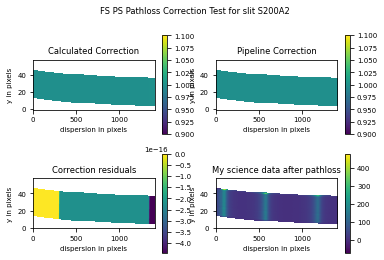

Calculating statistics... 

   Absolute Difference  :   mean = -1.848e-16    median = -2.220e-16    stdev = 1.074e-16
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
U

<Figure size 432x288 with 0 Axes>

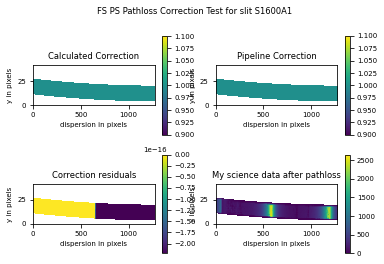

Calculating statistics... 

   Absolute Difference  :   mean = -1.084e-16    median = 0.000e+00    stdev = 1.110e-16
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '2.6757559816042584 minutes to finish.')


<Figure size 432x288 with 0 Axes>

In [7]:
# Run the validation test
%matplotlib inline

if "point" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     extract2d_file=extract2d_file,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
elif "extend" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     extract2d_file=extract2d_file,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)


In [8]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for FS FULL-FRAME test passed? ", result_msg)


Did assign_wcs validation for FS FULL-FRAME test passed?  All slits PASSED path_loss test.


<a id="ALLSLITS"></a>
# FS ALLSLITS test

In [11]:
# Set the variables for ALLSLITS data
data_directory = os.path.join(test_data_path, 'FS_ALLSLITS/G140H_F100LP')
prev_step_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_F100LP_srctype.fits')
mode_used = 'FS'
comparison_file = prev_step_file.replace('srctype', 'pathloss')
extract2d_file = prev_step_file.replace('srctype', 'extract_2d')

In [12]:
# Run the pipeline step
pipe_result = PathLossStep.call(prev_step_file)

2020-09-25 15:55:16,161 - CRDS - ERROR -  Error determining best reference for 'pars-pathlossstep'  =   Unknown reference type 'pars-pathlossstep'
2020-09-25 15:55:16,163 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2020-09-25 15:55:16,279 - stpipe.PathLossStep - INFO - Step PathLossStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G140H_F100LP/final_output_caldet1_NRS1_F100LP_srctype.fits',).
2020-09-25 15:55:16,281 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-25 15:55:18,384 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits
2020-09-25 15:55:18,441 - 

In [13]:
# Obtain other the information

# determine the type of source from the science header, choose the first science extension
srouce_type = fits.getval(prev_step_file, "SRCTYPE", "SCI", 1)

# get the corresponding reference file from the main header
reffile = pipe_result.meta.ref_file.pathloss.name.replace("crds://", "")
reffile_path = os.path.join(os.environ.get('CRDS_PATH'), 'references/jwst/nirspec/'+reffile)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G140H_F100LP/final_output_caldet1_NRS1_F100LP_srctype.fits
path_loss_file  -->  Grating:G140H   Filter:F100LP   EXP_TYPE:NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Checking if files exist & obtaining datamodels.
          This takes a few minutes...
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits


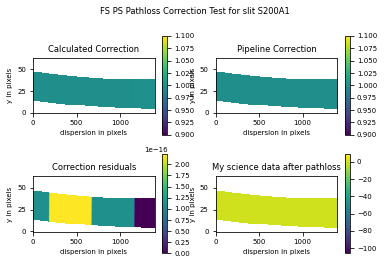

Calculating statistics... 

   Absolute Difference  :   mean = 1.308e-16    median = 1.110e-16    stdev = 7.750e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits


<Figure size 432x288 with 0 Axes>

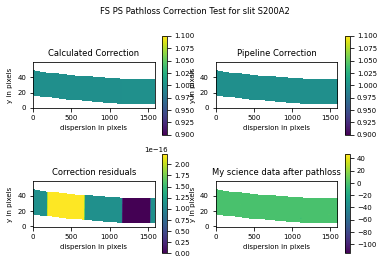

Calculating statistics... 

   Absolute Difference  :   mean = 1.193e-16    median = 1.110e-16    stdev = 8.104e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Usin

<Figure size 432x288 with 0 Axes>

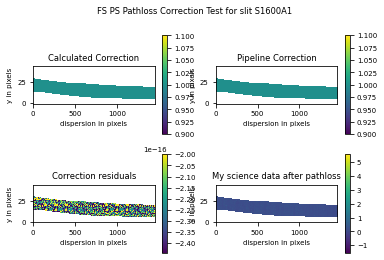

Calculating statistics... 

   Absolute Difference  :   mean = -2.220e-16    median = -2.220e-16    stdev = 0.000e+00
    Maximum   AbsoluteDifference = -2.220e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '2.675492016474406 minutes to finish.')


<Figure size 432x288 with 0 Axes>

In [14]:
# Run the validation test
%matplotlib inline

if "point" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     extract2d_file=extract2d_file,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
elif "extend" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     extract2d_file=extract2d_file,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)


In [15]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation test for FS ALLSLITS passed? ", result_msg)


Did assign_wcs validation test for FS ALLSLITS passed?  All slits PASSED path_loss test.


<a id="MOS"></a>
# MOS test

In [7]:
# Set the variables 
data_directory = os.path.join(test_data_path, 'MOS/G140M_LINE1')
prev_step_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_srctype.fits')
mode_used = 'MOS'
msa_conf_name = os.path.join(data_directory,'V8460001000101_msa.fits')
pipeline_pathloss_file = prev_step_file.replace('srctype', 'pathloss')

In [8]:
# Run the pipeline step
pipe_result = PathLossStep.call(prev_step_file)

2020-09-25 16:10:31,167 - CRDS - ERROR -  Error determining best reference for 'pars-pathlossstep'  =   Unknown reference type 'pars-pathlossstep'
2020-09-25 16:10:31,174 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2020-09-25 16:10:31,522 - stpipe.PathLossStep - INFO - Step PathLossStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1/final_output_caldet1_NRS1_srctype.fits',).
2020-09-25 16:10:31,524 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-25 16:10:51,347 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2020-09-25 16:10:51,432 - stpipe.PathLossS

In [9]:
# Obtain other the information

# determine the type of source from the science header, choose the first science extension
srouce_type = fits.getval(prev_step_file, "SRCTYPE", "SCI", 1)

# get the corresponding reference file from the main header
reffile = pipe_result.meta.ref_file.pathloss.name.replace("crds://", "")
reffile_path = os.path.join(os.environ.get('CRDS_PATH'), 'references/jwst/nirspec/'+reffile)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1/final_output_caldet1_NRS1_srctype.fits
path_loss_file:  Grating:G140M Filter:F100LP EXP_TYPE:NRS_MSASPEC
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
Checking if files exist and obtaining datamodels.
             This takes a few minutes...
 Looping through the slits... 
Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


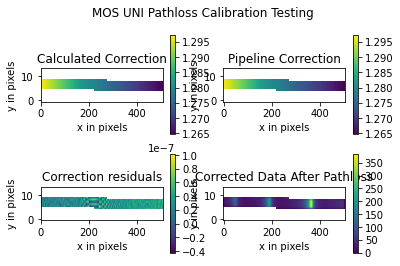

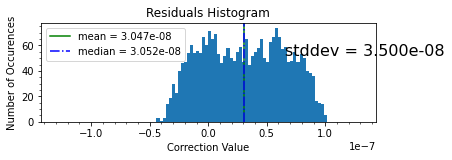

2020-09-25 16:11:23,816 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_mos_uni.py:355: RuntimeWarning: invalid value encountered in less
  & (corr_residuals > -0.1))]

2020-09-25 16:11:23,816 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_mos_uni.py:355: RuntimeWarning: invalid value encountered in greater
  & (corr_residuals > -0.1))]



Calculating statistics... 

   Absolute Difference  :   mean = 3.047e-08    median = 3.052e-08    stdev = 3.500e-08
    Maximum   AbsoluteDifference = 1.014e-07
    Minimum   AbsoluteDifference = -4.276e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


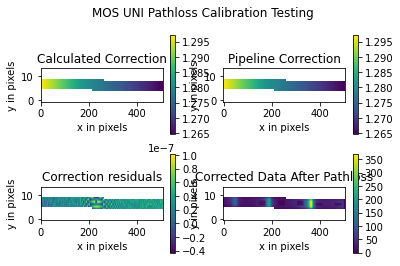

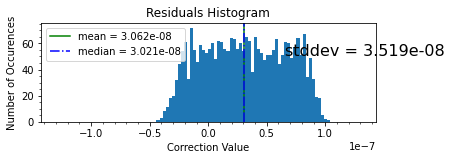

Calculating statistics... 

   Absolute Difference  :   mean = 3.062e-08    median = 3.021e-08    stdev = 3.519e-08
    Maximum   AbsoluteDifference = 1.017e-07
    Minimum   AbsoluteDifference = -4.294e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


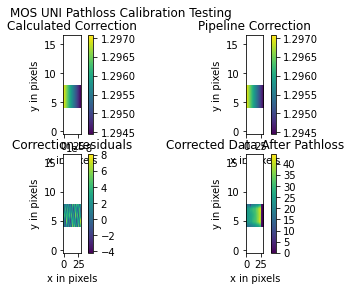

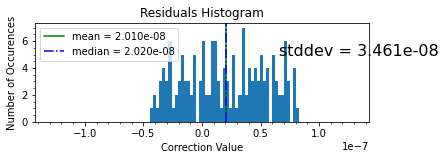

Calculating statistics... 

   Absolute Difference  :   mean = 2.010e-08    median = 2.020e-08    stdev = 3.461e-08
    Maximum   AbsoluteDifference = 8.104e-08
    Minimum   AbsoluteDifference = -4.209e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


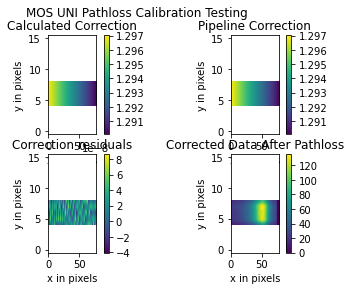

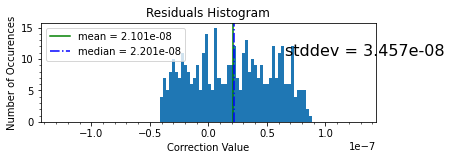

Calculating statistics... 

   Absolute Difference  :   mean = 2.101e-08    median = 2.201e-08    stdev = 3.457e-08
    Maximum   AbsoluteDifference = 8.671e-08
    Minimum   AbsoluteDifference = -4.049e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


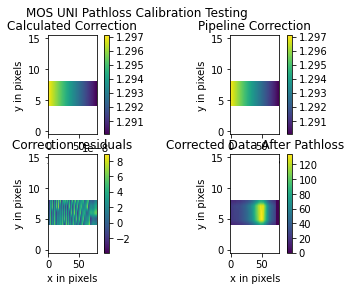

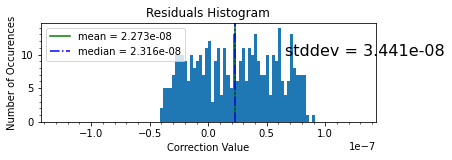

Calculating statistics... 

   Absolute Difference  :   mean = 2.273e-08    median = 2.316e-08    stdev = 3.441e-08
    Maximum   AbsoluteDifference = 8.906e-08
    Minimum   AbsoluteDifference = -3.935e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


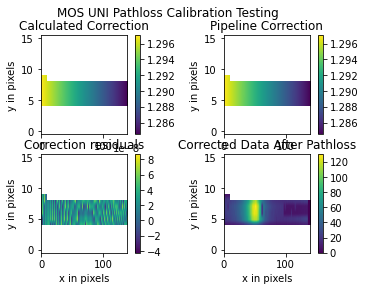

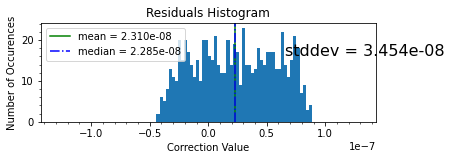

Calculating statistics... 

   Absolute Difference  :   mean = 2.310e-08    median = 2.285e-08    stdev = 3.454e-08
    Maximum   AbsoluteDifference = 8.712e-08
    Minimum   AbsoluteDifference = -4.240e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


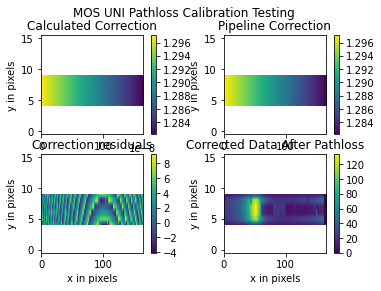

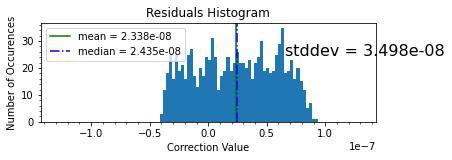

Calculating statistics... 

   Absolute Difference  :   mean = 2.338e-08    median = 2.435e-08    stdev = 3.498e-08
    Maximum   AbsoluteDifference = 9.236e-08
    Minimum   AbsoluteDifference = -4.059e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


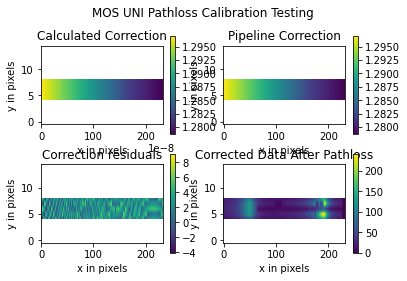

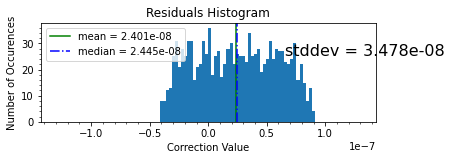

Calculating statistics... 

   Absolute Difference  :   mean = 2.401e-08    median = 2.445e-08    stdev = 3.478e-08
    Maximum   AbsoluteDifference = 9.073e-08
    Minimum   AbsoluteDifference = -4.101e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


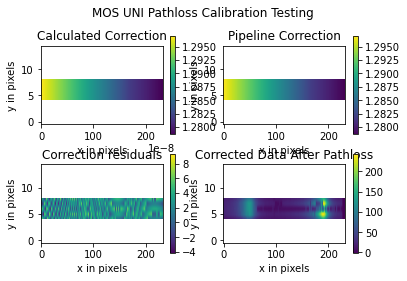

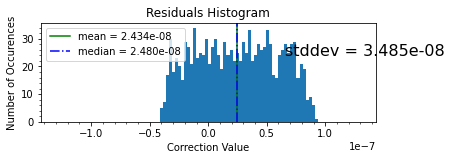

Calculating statistics... 

   Absolute Difference  :   mean = 2.434e-08    median = 2.480e-08    stdev = 3.485e-08
    Maximum   AbsoluteDifference = 9.280e-08
    Minimum   AbsoluteDifference = -4.149e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


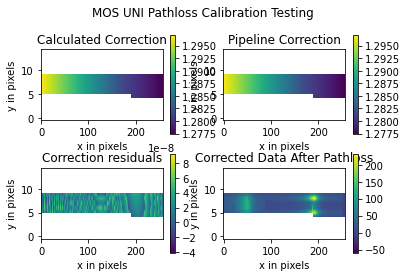

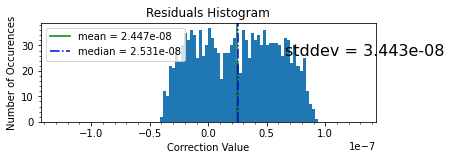

Calculating statistics... 

   Absolute Difference  :   mean = 2.447e-08    median = 2.531e-08    stdev = 3.443e-08
    Maximum   AbsoluteDifference = 9.232e-08
    Minimum   AbsoluteDifference = -4.066e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


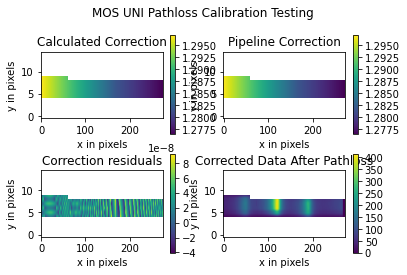

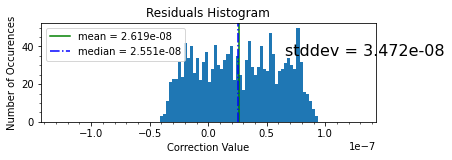

Calculating statistics... 

   Absolute Difference  :   mean = 2.619e-08    median = 2.551e-08    stdev = 3.472e-08
    Maximum   AbsoluteDifference = 9.211e-08
    Minimum   AbsoluteDifference = -4.060e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


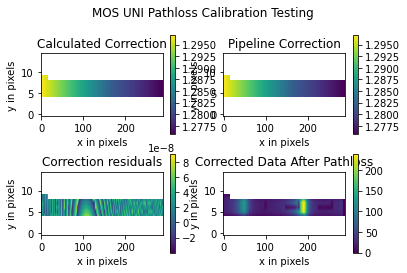

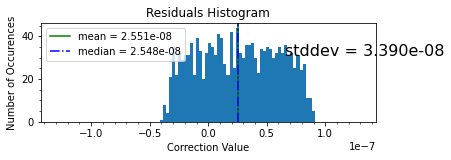

Calculating statistics... 

   Absolute Difference  :   mean = 2.551e-08    median = 2.548e-08    stdev = 3.390e-08
    Maximum   AbsoluteDifference = 9.070e-08
    Minimum   AbsoluteDifference = -3.983e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


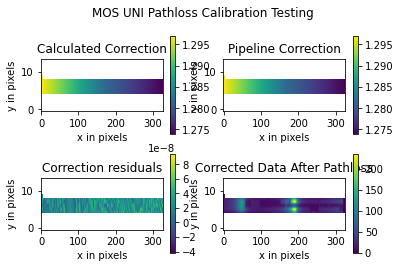

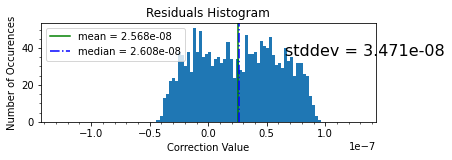

Calculating statistics... 

   Absolute Difference  :   mean = 2.568e-08    median = 2.608e-08    stdev = 3.471e-08
    Maximum   AbsoluteDifference = 9.395e-08
    Minimum   AbsoluteDifference = -4.211e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


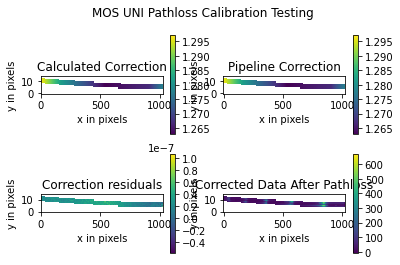

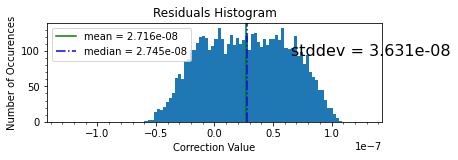

Calculating statistics... 

   Absolute Difference  :   mean = 2.716e-08    median = 2.745e-08    stdev = 3.631e-08
    Maximum   AbsoluteDifference = 1.076e-07
    Minimum   AbsoluteDifference = -5.777e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


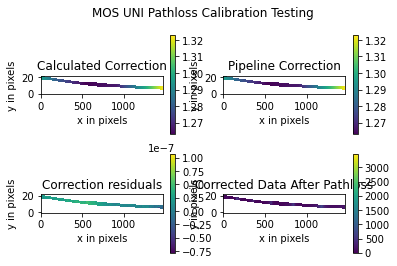

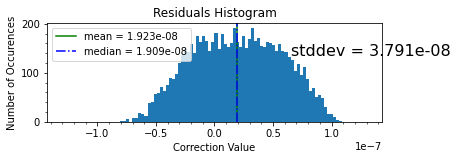

Calculating statistics... 

   Absolute Difference  :   mean = 1.923e-08    median = 1.909e-08    stdev = 3.791e-08
    Maximum   AbsoluteDifference = 1.067e-07
    Minimum   AbsoluteDifference = -7.844e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


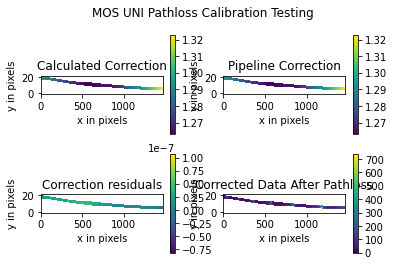

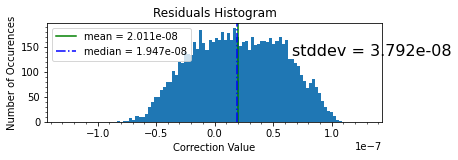

Calculating statistics... 

   Absolute Difference  :   mean = 2.011e-08    median = 1.947e-08    stdev = 3.792e-08
    Maximum   AbsoluteDifference = 1.071e-07
    Minimum   AbsoluteDifference = -8.173e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


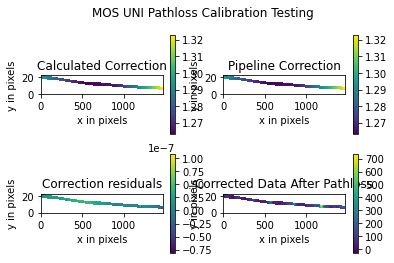

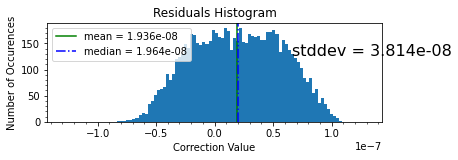

Calculating statistics... 

   Absolute Difference  :   mean = 1.936e-08    median = 1.964e-08    stdev = 3.814e-08
    Maximum   AbsoluteDifference = 1.076e-07
    Minimum   AbsoluteDifference = -8.090e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


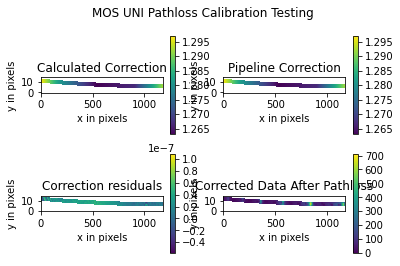

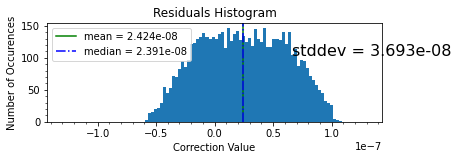

Calculating statistics... 

   Absolute Difference  :   mean = 2.424e-08    median = 2.391e-08    stdev = 3.693e-08
    Maximum   AbsoluteDifference = 1.080e-07
    Minimum   AbsoluteDifference = -5.845e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


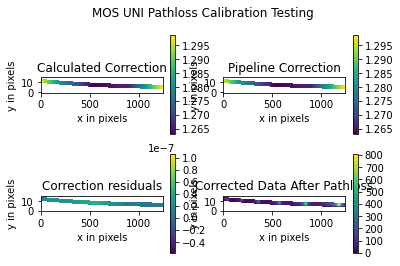

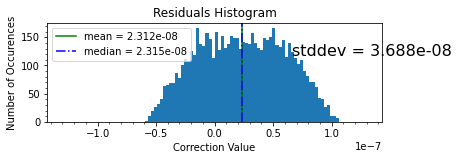

Calculating statistics... 

   Absolute Difference  :   mean = 2.312e-08    median = 2.315e-08    stdev = 3.688e-08
    Maximum   AbsoluteDifference = 1.062e-07
    Minimum   AbsoluteDifference = -5.818e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


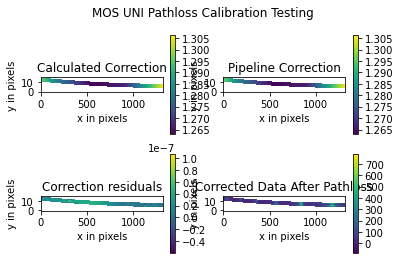

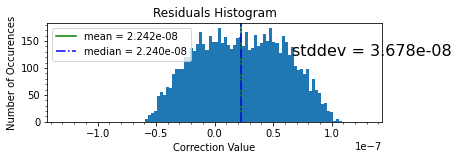

Calculating statistics... 

   Absolute Difference  :   mean = 2.242e-08    median = 2.240e-08    stdev = 3.678e-08
    Maximum   AbsoluteDifference = 1.072e-07
    Minimum   AbsoluteDifference = -5.979e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


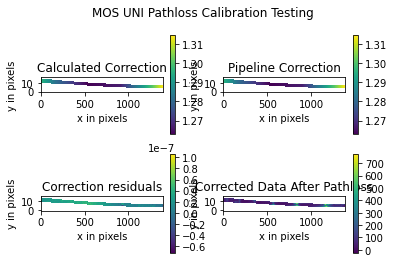

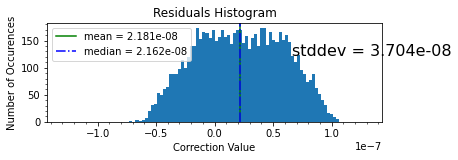

Calculating statistics... 

   Absolute Difference  :   mean = 2.181e-08    median = 2.162e-08    stdev = 3.704e-08
    Maximum   AbsoluteDifference = 1.063e-07
    Minimum   AbsoluteDifference = -7.136e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


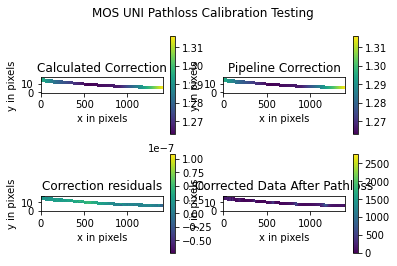

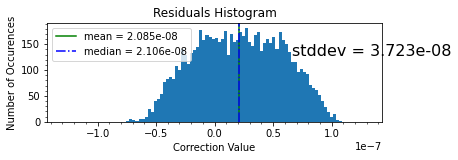

Calculating statistics... 

   Absolute Difference  :   mean = 2.085e-08    median = 2.106e-08    stdev = 3.723e-08
    Maximum   AbsoluteDifference = 1.087e-07
    Minimum   AbsoluteDifference = -7.340e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


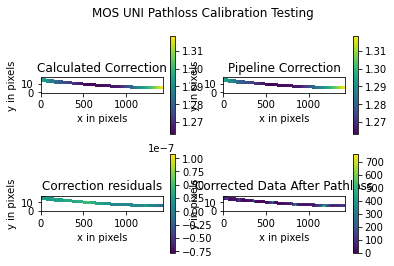

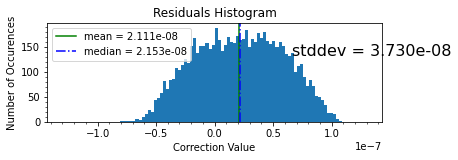

Calculating statistics... 

   Absolute Difference  :   mean = 2.111e-08    median = 2.153e-08    stdev = 3.730e-08
    Maximum   AbsoluteDifference = 1.076e-07
    Minimum   AbsoluteDifference = -7.841e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


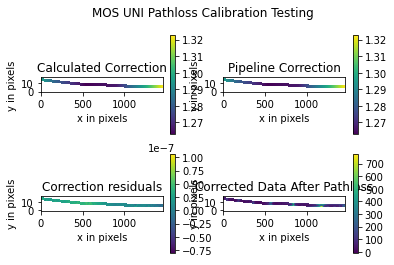

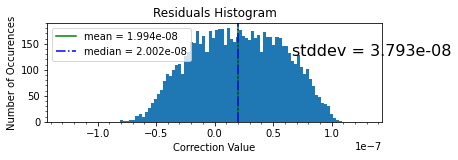

Calculating statistics... 

   Absolute Difference  :   mean = 1.994e-08    median = 2.002e-08    stdev = 3.793e-08
    Maximum   AbsoluteDifference = 1.067e-07
    Minimum   AbsoluteDifference = -7.998e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


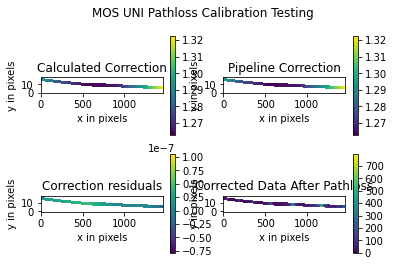

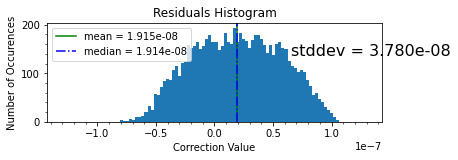

Calculating statistics... 

   Absolute Difference  :   mean = 1.915e-08    median = 1.914e-08    stdev = 3.780e-08
    Maximum   AbsoluteDifference = 1.049e-07
    Minimum   AbsoluteDifference = -7.958e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


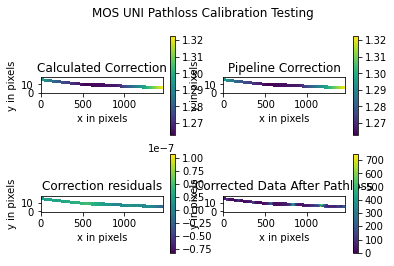

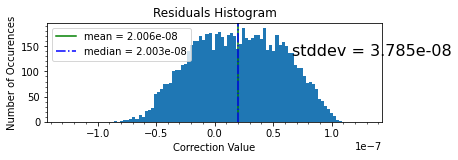

Calculating statistics... 

   Absolute Difference  :   mean = 2.006e-08    median = 2.003e-08    stdev = 3.785e-08
    Maximum   AbsoluteDifference = 1.073e-07
    Minimum   AbsoluteDifference = -8.405e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED

Retrieving extensions
Retrieved extended source extension 3
plcor_ref_ext.shape (21,)


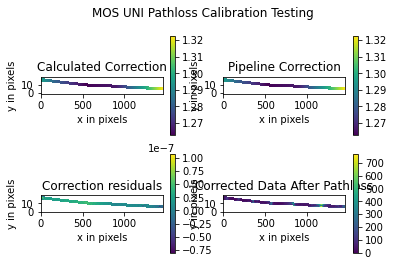

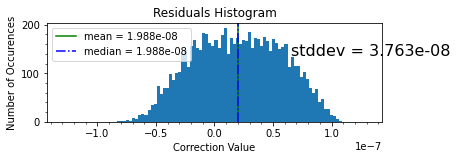

Calculating statistics... 

   Absolute Difference  :   mean = 1.988e-08    median = 1.988e-08    stdev = 3.763e-08
    Maximum   AbsoluteDifference = 1.070e-07
    Minimum   AbsoluteDifference = -8.163e-08
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final result for path_loss test will be reported as PASSED *** 

('* Script msa_uni.py took ', '47.55437111854553 seconds to finish.')


In [10]:
# Run the validation test
%matplotlib inline

if "point" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_ps.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
elif "extend" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_uni.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)



In [11]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for MOS test passed? ", result_msg)


Did assign_wcs validation for MOS test passed?  All slits PASSED path_loss test.


<a id="IFU"></a>
# IFU test

In [4]:
# Set the variables 
data_directory = os.path.join(test_data_path, 'IFU_CV3/G395H_OPAQUE')
prev_step_file = os.path.join(data_directory, 'final_output_caldet1_NRS2_srctype.fits')
mode_used = 'IFU'
pipeline_pathloss_file = prev_step_file.replace('srctype', 'pathloss')

In [5]:
# Run the pipeline step
pipe_result = PathLossStep.call(prev_step_file)

2020-09-25 17:11:54,377 - CRDS - ERROR -  Error determining best reference for 'pars-pathlossstep'  =   Unknown reference type 'pars-pathlossstep'
2020-09-25 17:11:54,380 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2020-09-25 17:11:54,780 - stpipe.PathLossStep - INFO - Step PathLossStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE/final_output_caldet1_NRS2_srctype.fits',).
2020-09-25 17:11:54,781 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-25 17:12:09,651 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits
2020-09-25 17:12:09,703 - stpipe.Path

In [6]:
# Obtain other the information

# determine the type of source from the science header, choose the first science extension
srouce_type = fits.getval(prev_step_file, "SRCTYPE", "SCI", 1)

# get the corresponding reference file from the main header
reffile = pipe_result.meta.ref_file.pathloss.name.replace("crds://", "")
reffile_path = os.path.join(os.environ.get('CRDS_PATH'), 'references/jwst/nirspec/'+reffile)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE/final_output_caldet1_NRS2_srctype.fits
pathloss_file: Grating:G395H  Filter:F290LP  EXP_TYPE:NRS_IFU
Using reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits
Checking if files exist and obtaining datamodels.
             This takes a few minutes...


2020-09-25 17:17:01,260 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_ifu_uni.py:159: RuntimeWarning: invalid value encountered in true_divide
  pathloss_divided = comp_sci/previous_sci



got input slices
PLCOR_REF.shape (21, 21, 21)
 Looping through the slices... 
working with slice 0
SHAPES (52, 1677) (51, 1677)
ALTERED SHAPE OF SLICE: V2
final left 780, right 831, top 1677, bottom 0
NEW SHAPE OF SLICE: (51, 1677) and corr_vals.shape: (51, 1677)


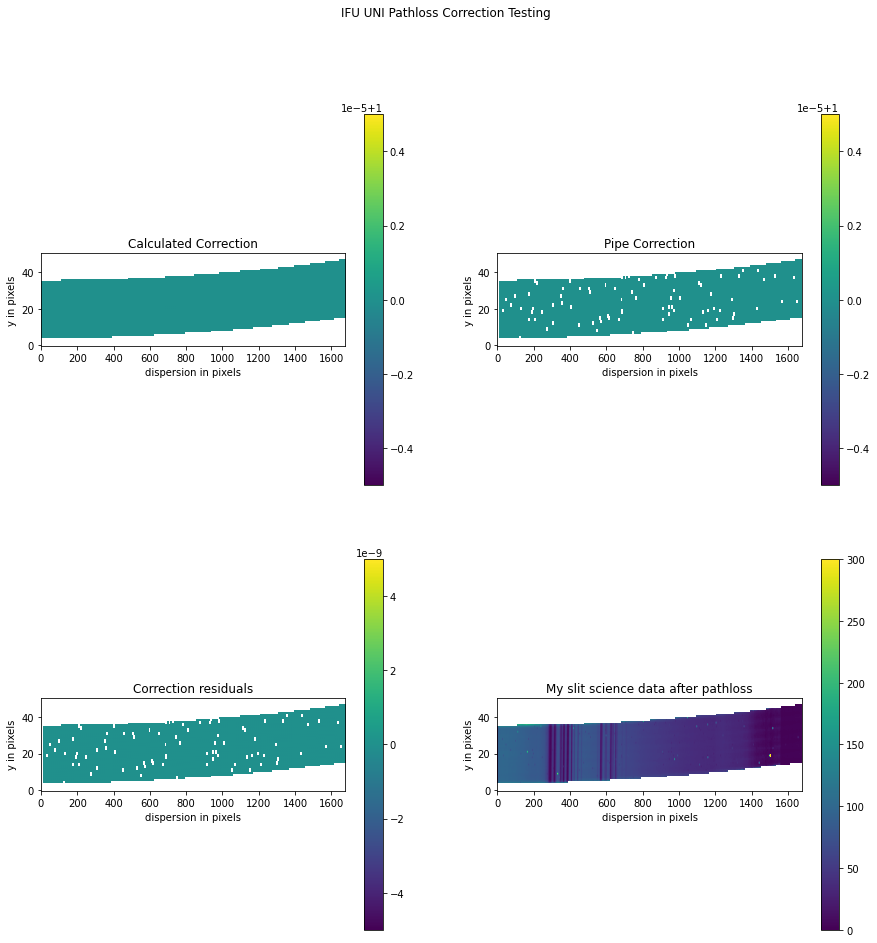

working with slice 1
SHAPES (52, 1721) (53, 1722)
ALTERED SHAPE OF SLICE: V4
ALTERED SHAPE OF SLICE: V8
final left 1195, right 1248, top 1721, bottom -1
NEW SHAPE OF SLICE: (53, 0) and corr_vals.shape: (53, 1722)
ALTERED SHAPE OF SLICE: V7
final left 1195, right 1248, top 1722, bottom -2
NEW SHAPE OF SLICE: (53, 0) and corr_vals.shape: (53, 1722)
ALTERED SHAPE OF SLICE: V7
final left 1195, right 1248, top 1723, bottom -3
NEW SHAPE OF SLICE: (53, 0) and corr_vals.shape: (53, 1722)
ALTERED SHAPE OF SLICE: V7
final left 1195, right 1248, top 1724, bottom -4
NEW SHAPE OF SLICE: (53, 0) and corr_vals.shape: (53, 1722)
ALTERED SHAPE OF SLICE: V7
final left 1195, right 1248, top 1725, bottom -5
NEW SHAPE OF SLICE: (53, 0) and corr_vals.shape: (53, 1722)
ALTERED SHAPE OF SLICE: V7
final left 1195, right 1248, top 1726, bottom -6
NEW SHAPE OF SLICE: (53, 0) and corr_vals.shape: (53, 1722)
shapes did not match! full_cut2slice: (53, 0), corr_vals (53, 1722)
working with slice 2
SHAPES (51, 1672) 

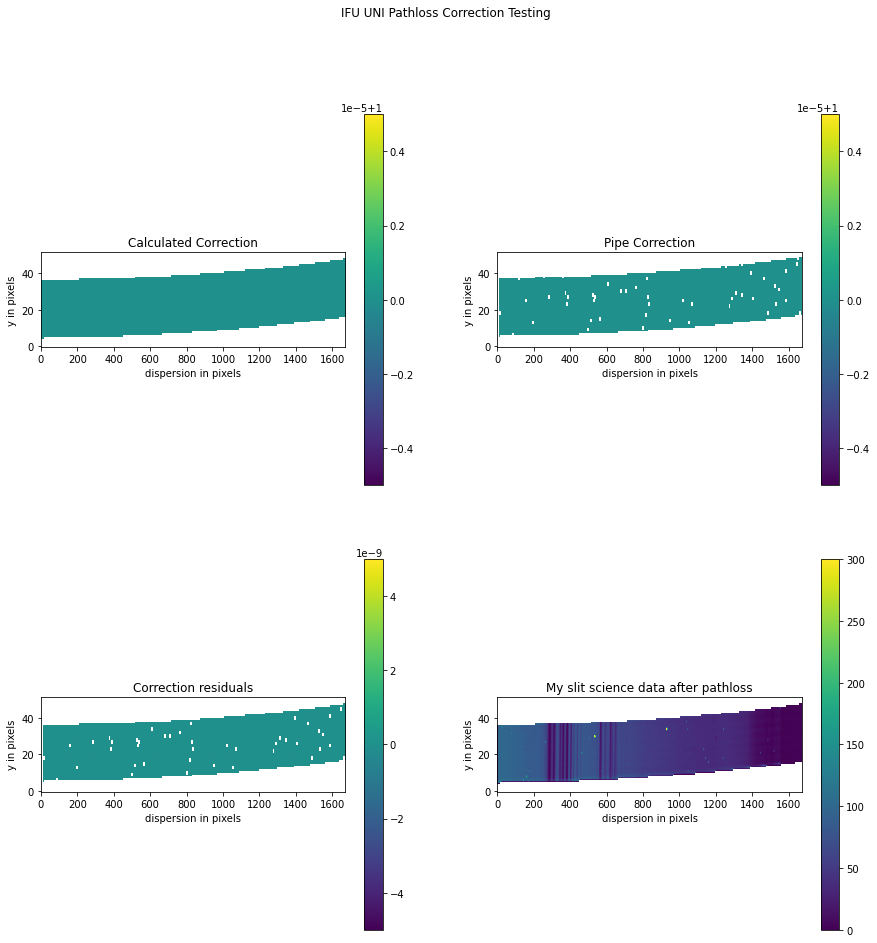

working with slice 3
SHAPES (52, 1726) (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -1
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -2
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -3
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -4
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -5
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -6
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727)
ALTERED SHAPE OF SLICE: V8
final left 1245, right 1297, top 1726, bottom -7
NEW SHAPE OF SLICE: (52, 0) and corr_vals.shape: (52, 1727

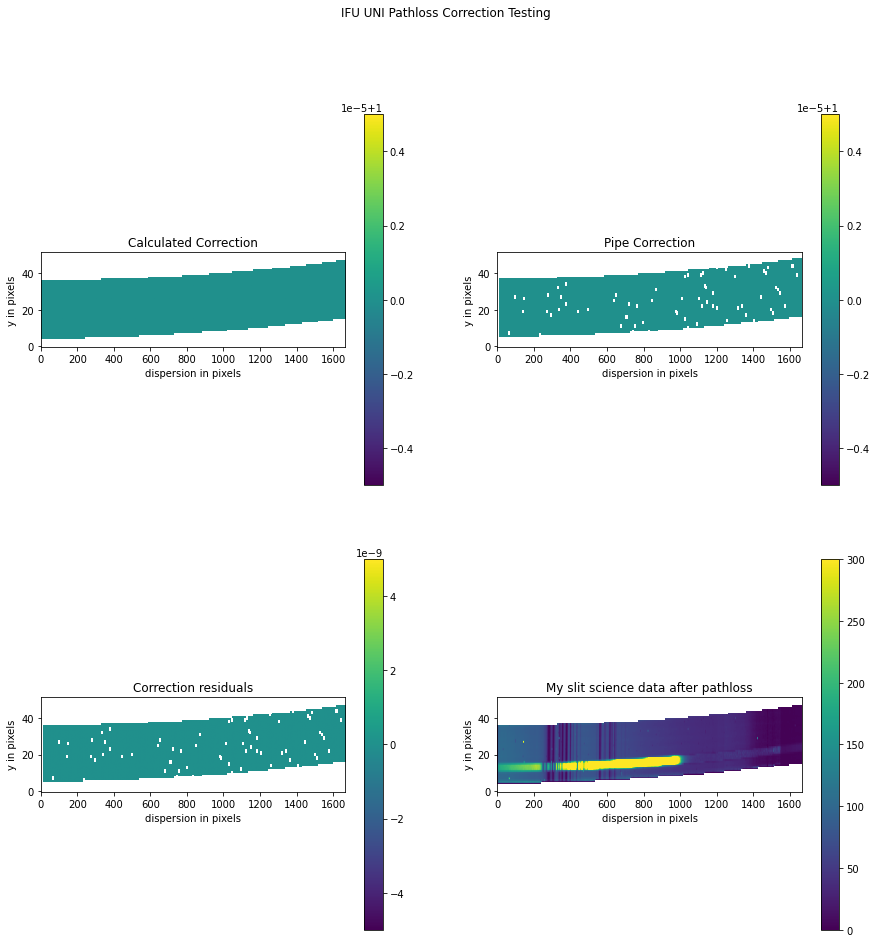

working with slice 5
SHAPES (53, 1732) (52, 1732)
ALTERED SHAPE OF SLICE: V2
final left 1295, right 1347, top 1732, bottom 0
NEW SHAPE OF SLICE: (52, 1732) and corr_vals.shape: (52, 1732)


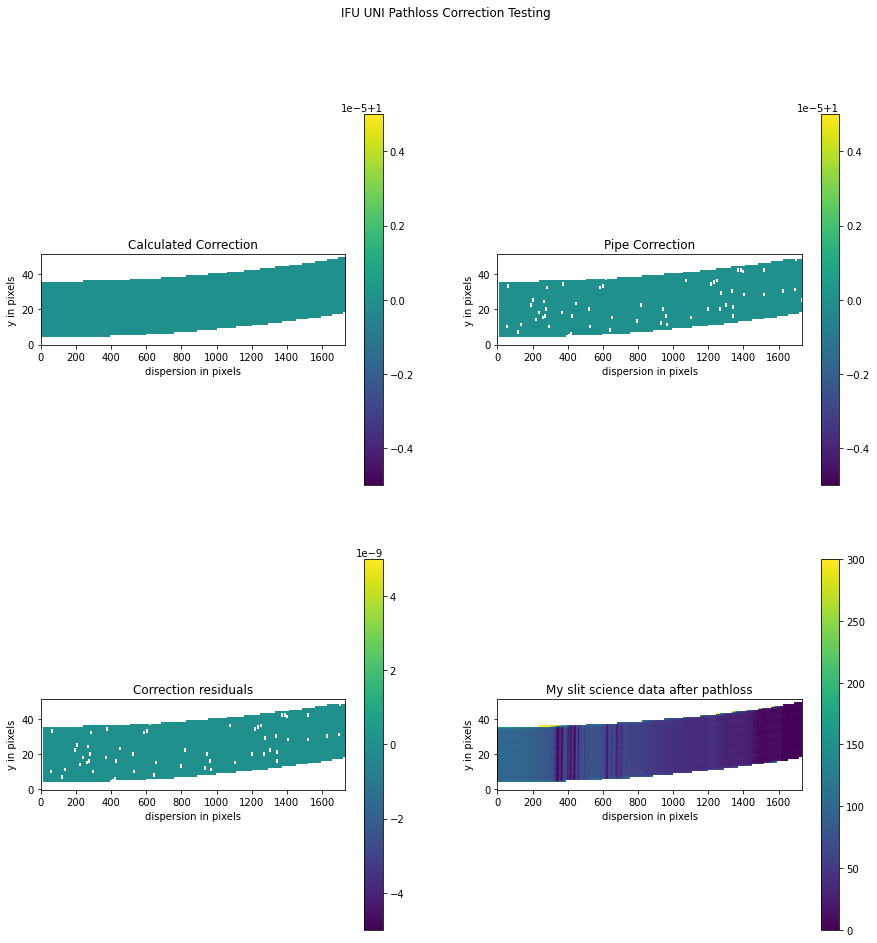

working with slice 6
SHAPES (52, 1662) (51, 1663)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 632, right 683, top 1662, bottom -1
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1663)
ALTERED SHAPE OF SLICE: V8
final left 632, right 683, top 1662, bottom -2
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1663)
ALTERED SHAPE OF SLICE: V8
final left 632, right 683, top 1662, bottom -3
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1663)
ALTERED SHAPE OF SLICE: V8
final left 632, right 683, top 1662, bottom -4
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1663)
ALTERED SHAPE OF SLICE: V8
final left 632, right 683, top 1662, bottom -5
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1663)
ALTERED SHAPE OF SLICE: V8
final left 632, right 683, top 1662, bottom -6
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1663)
shapes did not match! full_cut2slice: (51, 0), corr_vals (51, 1663)
working with slice 7
SHAPES (53, 1737) (52, 1738)
A

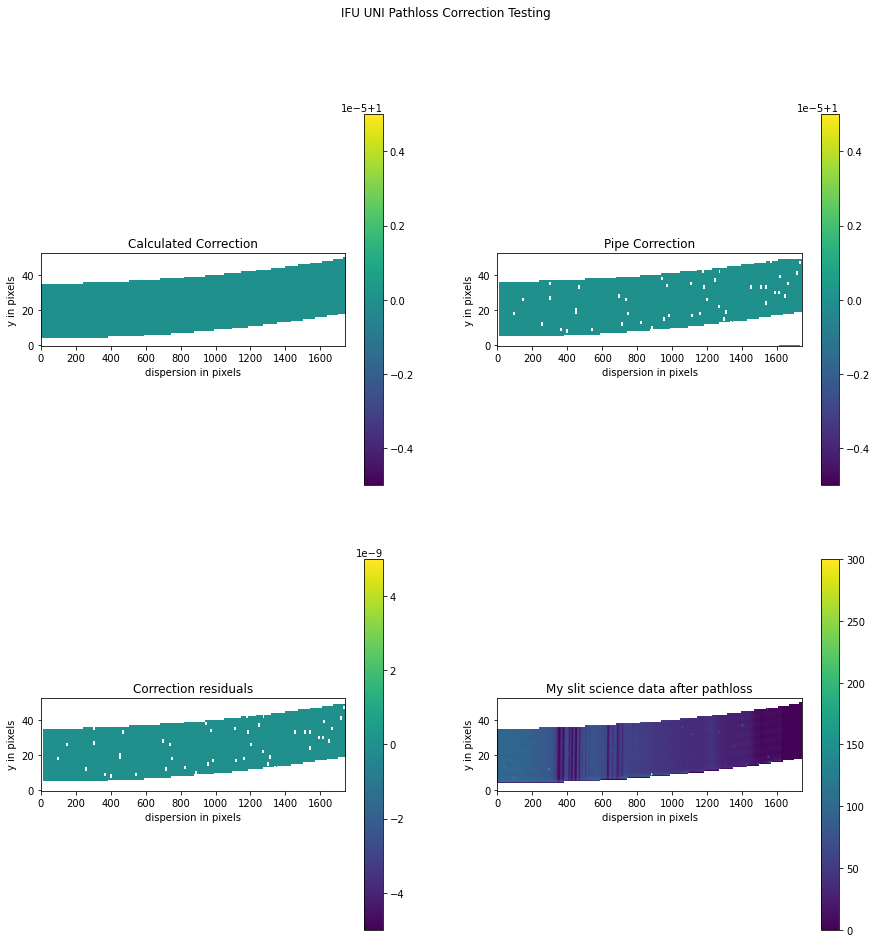

working with slice 10
SHAPES (51, 1653) (52, 1653)
ALTERED SHAPE OF SLICE: V4
final left 532, right 584, top 1653, bottom 0
NEW SHAPE OF SLICE: (52, 1653) and corr_vals.shape: (52, 1653)


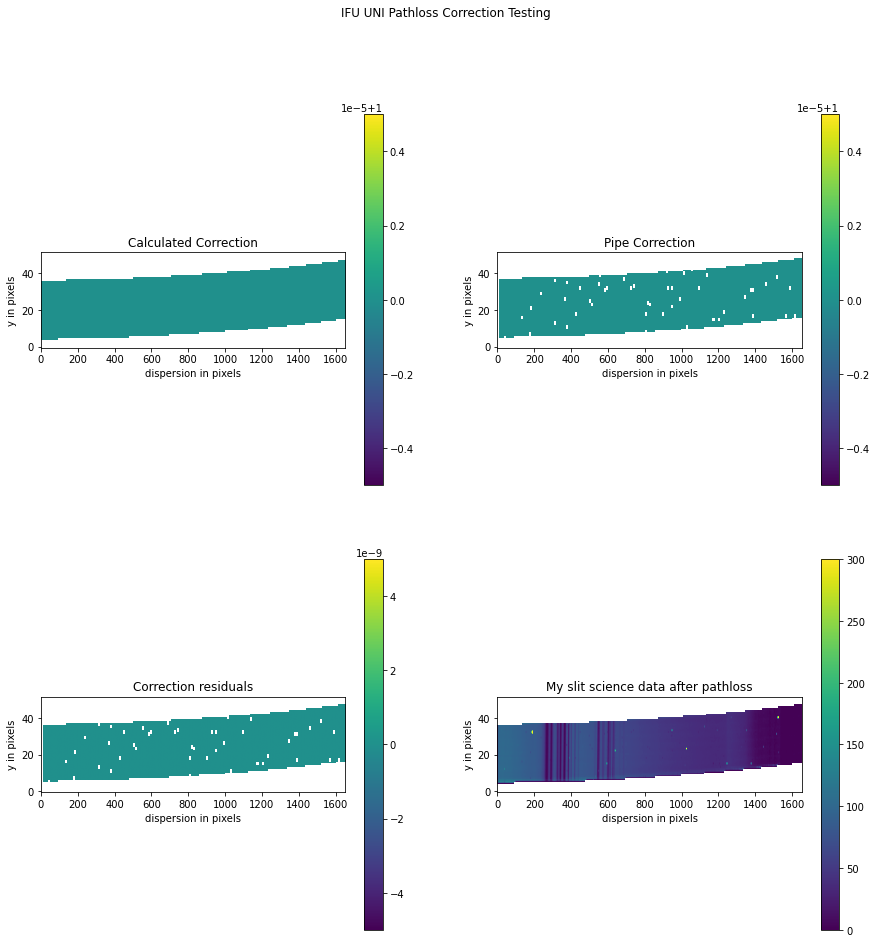

working with slice 11
SHAPES (53, 1749) (53, 1749)


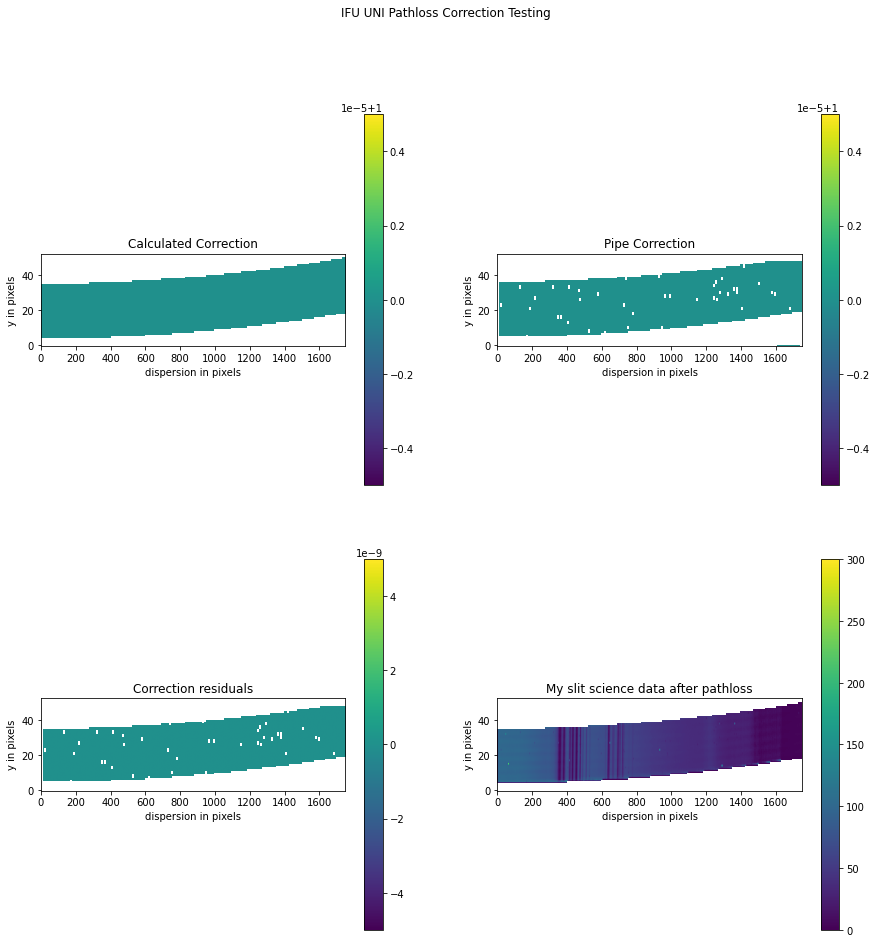

working with slice 12
SHAPES (51, 1648) (52, 1648)
ALTERED SHAPE OF SLICE: V4
final left 483, right 535, top 1648, bottom 0
NEW SHAPE OF SLICE: (52, 1648) and corr_vals.shape: (52, 1648)


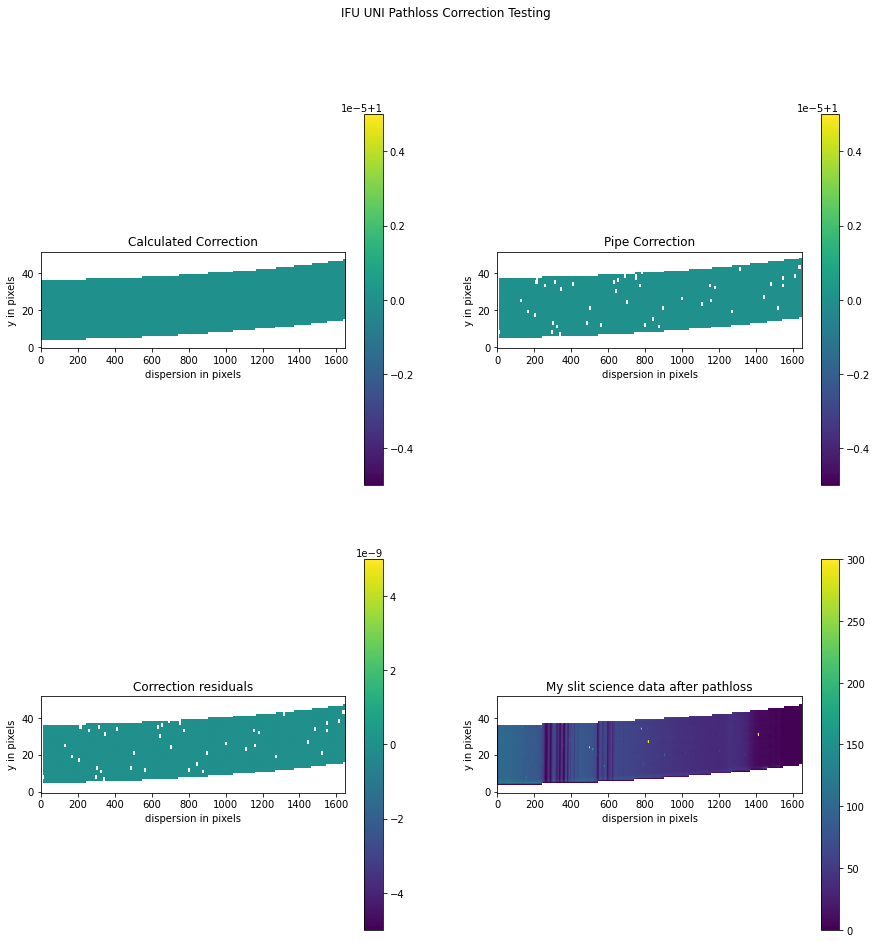

working with slice 13
SHAPES (54, 1754) (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -1
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -2
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -3
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -4
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -5
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -6
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1755)
ALTERED SHAPE OF SLICE: V8
final left 1490, right 1544, top 1754, bottom -7
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 175

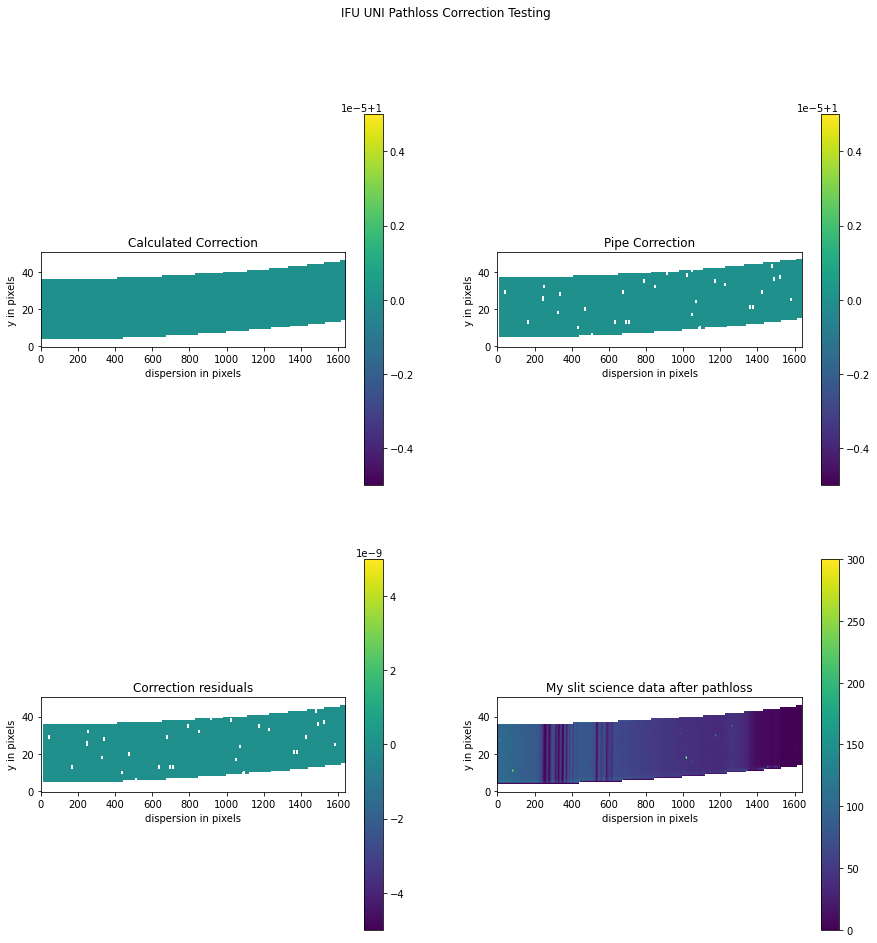

working with slice 17
SHAPES (54, 1766) (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -1
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -2
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -3
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -4
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -5
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -6
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 1767)
ALTERED SHAPE OF SLICE: V8
final left 1588, right 1642, top 1766, bottom -7
NEW SHAPE OF SLICE: (54, 0) and corr_vals.shape: (54, 176

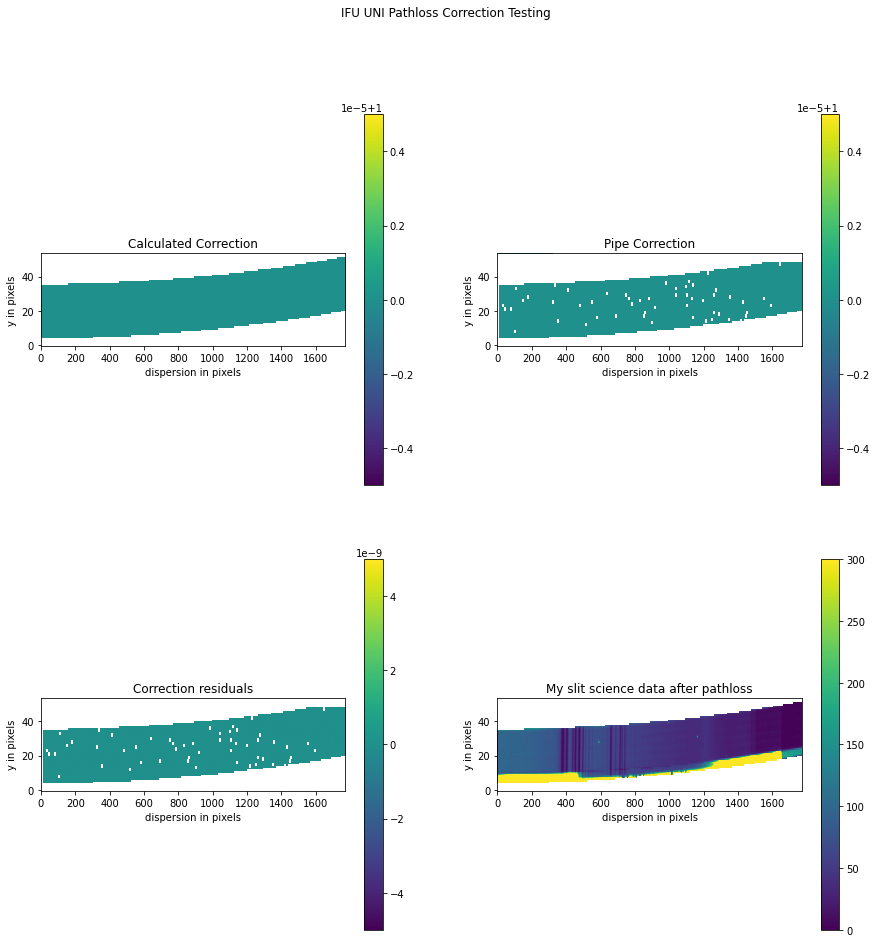

working with slice 20
SHAPES (52, 1630) (51, 1630)
ALTERED SHAPE OF SLICE: V2
final left 287, right 338, top 1630, bottom 0
NEW SHAPE OF SLICE: (51, 1630) and corr_vals.shape: (51, 1630)


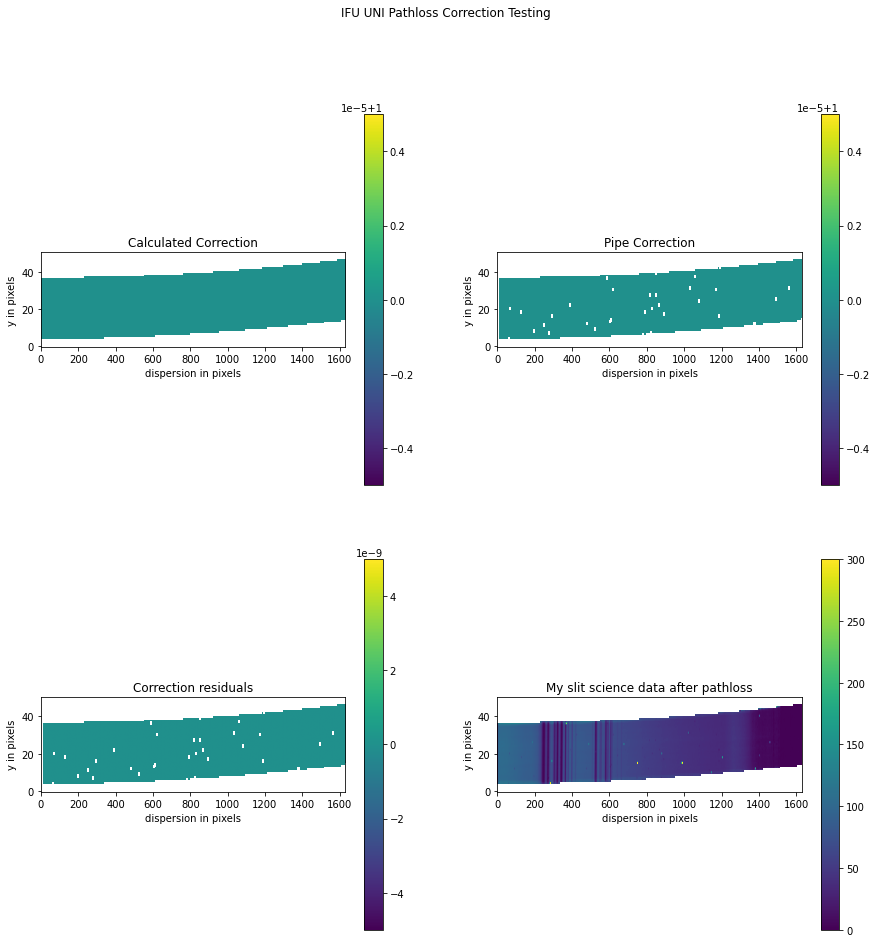

working with slice 21
SHAPES (55, 1778) (55, 1778)


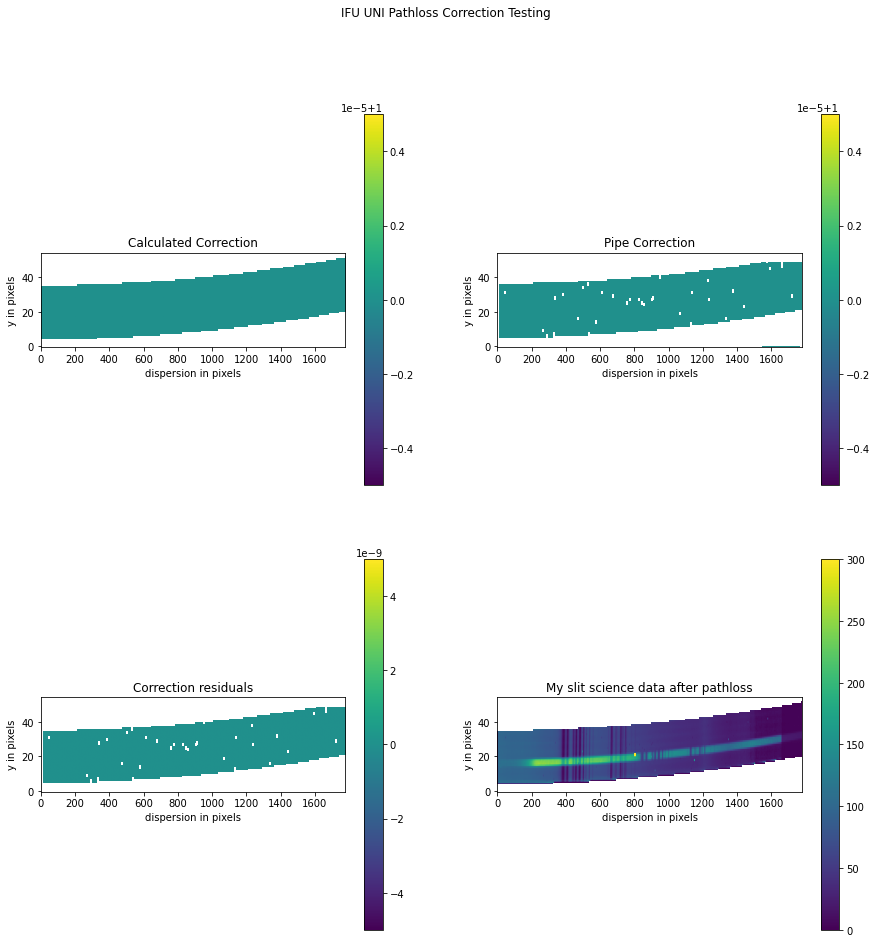

working with slice 22
SHAPES (51, 1625) (51, 1626)
ALTERED SHAPE OF SLICE: V8
final left 237, right 288, top 1625, bottom -1
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
ALTERED SHAPE OF SLICE: V7
final left 237, right 288, top 1626, bottom -2
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
ALTERED SHAPE OF SLICE: V7
final left 237, right 288, top 1627, bottom -3
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
ALTERED SHAPE OF SLICE: V7
final left 237, right 288, top 1628, bottom -4
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
ALTERED SHAPE OF SLICE: V7
final left 237, right 288, top 1629, bottom -5
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
ALTERED SHAPE OF SLICE: V7
final left 237, right 288, top 1630, bottom -6
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
ALTERED SHAPE OF SLICE: V7
final left 237, right 288, top 1631, bottom -7
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1626)
shapes did 

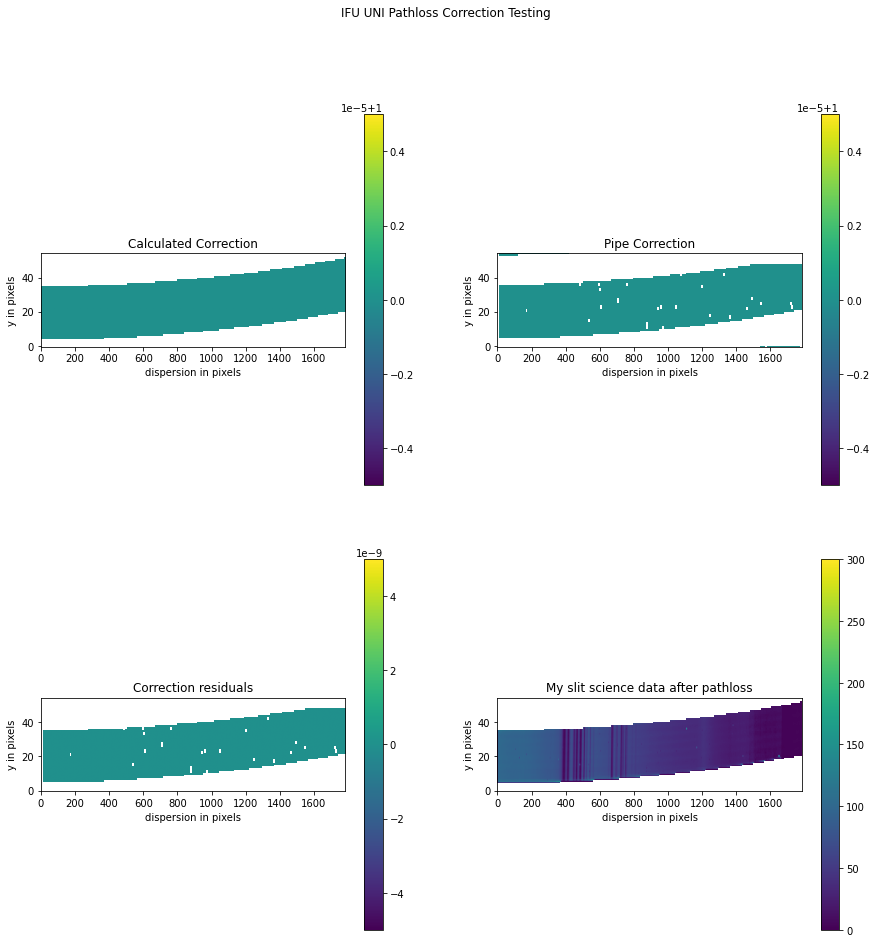

working with slice 24
SHAPES (51, 1621) (52, 1621)
ALTERED SHAPE OF SLICE: V4
final left 187, right 239, top 1621, bottom 0
NEW SHAPE OF SLICE: (52, 1621) and corr_vals.shape: (52, 1621)


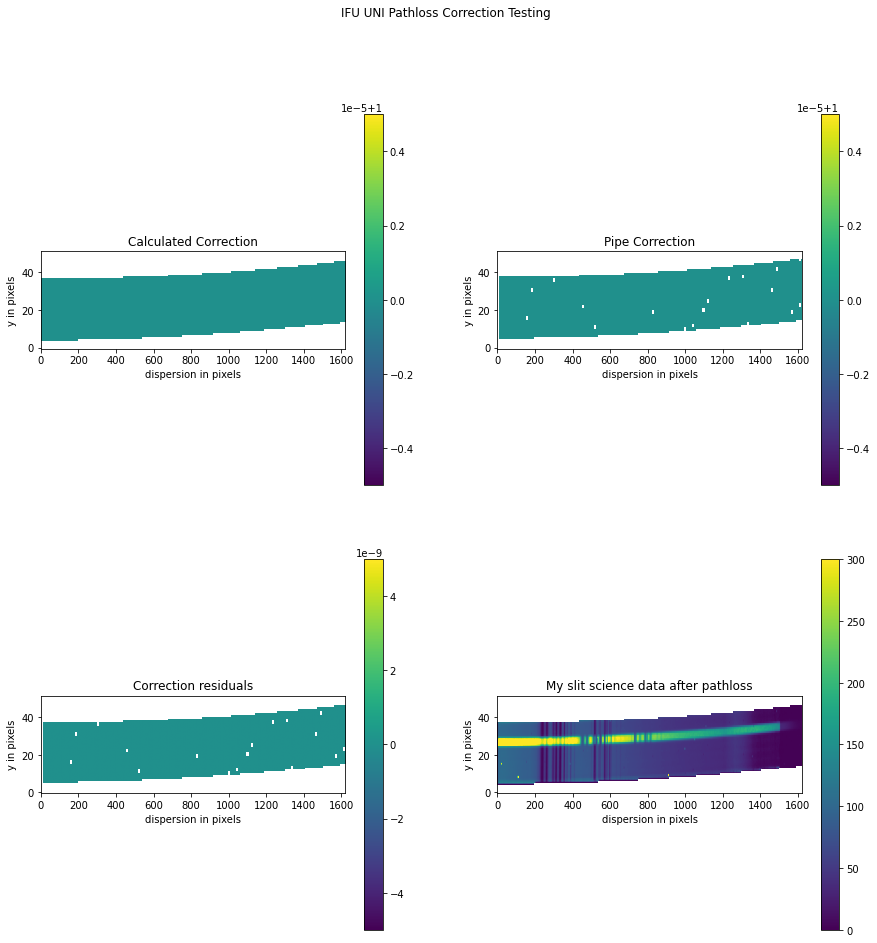

working with slice 25
SHAPES (55, 1790) (56, 1790)
ALTERED SHAPE OF SLICE: V4
final left 1782, right 1838, top 1790, bottom 0
NEW SHAPE OF SLICE: (56, 1790) and corr_vals.shape: (56, 1790)


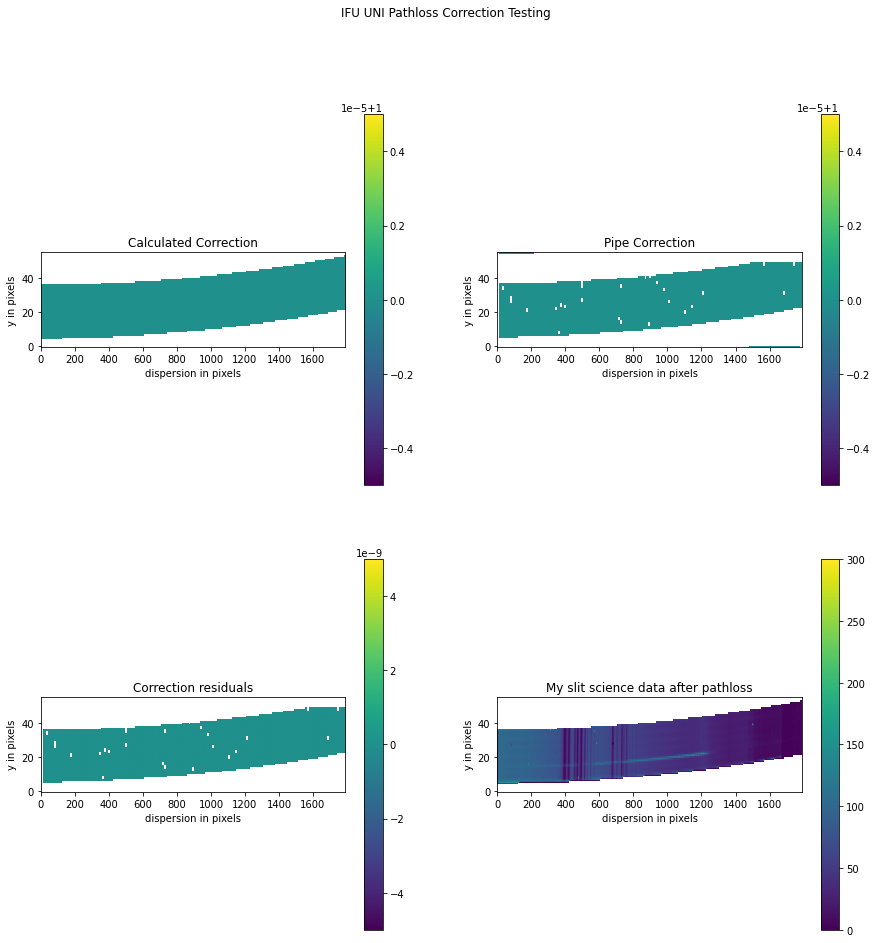

working with slice 26
SHAPES (52, 1617) (51, 1617)
ALTERED SHAPE OF SLICE: V2
final left 139, right 190, top 1617, bottom 0
NEW SHAPE OF SLICE: (51, 1617) and corr_vals.shape: (51, 1617)


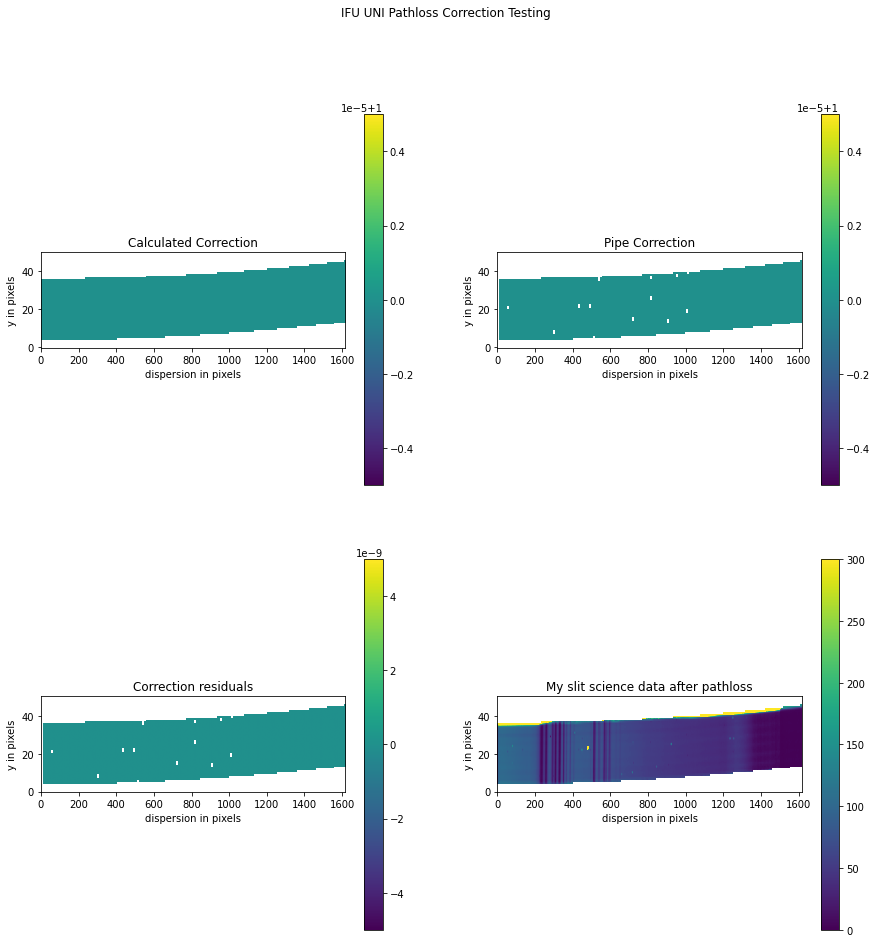

working with slice 27
SHAPES (55, 1796) (56, 1797)
ALTERED SHAPE OF SLICE: V4
ALTERED SHAPE OF SLICE: V8
final left 1831, right 1887, top 1796, bottom -1
NEW SHAPE OF SLICE: (56, 0) and corr_vals.shape: (56, 1797)
ALTERED SHAPE OF SLICE: V8
final left 1831, right 1887, top 1796, bottom -2
NEW SHAPE OF SLICE: (56, 0) and corr_vals.shape: (56, 1797)
ALTERED SHAPE OF SLICE: V8
final left 1831, right 1887, top 1796, bottom -3
NEW SHAPE OF SLICE: (56, 0) and corr_vals.shape: (56, 1797)
ALTERED SHAPE OF SLICE: V8
final left 1831, right 1887, top 1796, bottom -4
NEW SHAPE OF SLICE: (56, 0) and corr_vals.shape: (56, 1797)
ALTERED SHAPE OF SLICE: V8
final left 1831, right 1887, top 1796, bottom -5
NEW SHAPE OF SLICE: (56, 0) and corr_vals.shape: (56, 1797)
ALTERED SHAPE OF SLICE: V8
final left 1831, right 1887, top 1796, bottom -6
NEW SHAPE OF SLICE: (56, 0) and corr_vals.shape: (56, 1797)
shapes did not match! full_cut2slice: (56, 0), corr_vals (56, 1797)
working with slice 28


2020-09-25 17:17:16,706 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_ifu_uni.py:355: RuntimeWarning: invalid value encountered in less
  & (corr_residuals > -0.1))]

2020-09-25 17:17:16,706 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_ifu_uni.py:355: RuntimeWarning: invalid value encountered in greater
  & (corr_residuals > -0.1))]



SHAPES (51, 1612) (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -1
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -2
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -3
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -4
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -5
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -6
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
ALTERED SHAPE OF SLICE: V8
final left 89, right 140, top 1612, bottom -7
NEW SHAPE OF SLICE: (51, 0) and corr_vals.shape: (51, 1613)
shapes did not match! full_cut2slice: (5

In [7]:
# Run the validation test
%matplotlib inline

if "point" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_ps.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
elif "extend" in srouce_type.lower():
    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_uni.pathtest(
                                                                                     prev_step_file, 
                                                                                     reffile_path,
                                                                                     pipe_result,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)



In [8]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for IFU test passed? ", result_msg)


Did assign_wcs validation for IFU test passed?  All slits PASSED path_loss test.


<a id="results"></a>
## Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.

<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** Sept/25/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 